# Testing new Analysis Module for multiple files

In [ ]:
''' PULLING FILE PATHS FROM A DIR '''
import os 
# Define the subdirectory to search within
subdir = "data/trial1/nostruct/5_0/3_300"
paths = []

# Populate paths with everything in the specified subdirectory
for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
    for file in files:
        if file.endswith('.dat'):
            path = os.path.join(root, file)
            path = path.replace("\\", "/")  # Replace backslashes with forward slashes
            path = path[-43:]
            paths.append(path)
# print(paths)

In [ ]:
""" 
Get relative paths function; works for any path 

"""

def get_relative_paths(subdir):

    import os
    # Define the subdirectory to search within
    paths = []

    # Populate paths with everything in the specified subdirectory
    for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
        for file in files:
            if file.endswith('.dat'):
                path = os.path.join(root, file)
                path = path.replace("\\", "/")  # Replace backslashes with forward slashes
                relative_path = os.path.relpath(path, os.path.join(os.getcwd(), subdir))
                paths.append(relative_path)

    paths = [os.path.join(subdir, path) for path in paths]
    paths = [path.replace("\\", "/") for path in paths]

    return paths

# Example usage:
subdir = "data/trial1/nostruct/5_0/300_3"
subdir = "old"
paths = get_relative_paths(subdir)

# Add subdir to all relative paths
# paths = [os.path.join(subdir, path) for path in paths]
# paths = [path.replace("\\", "/") for path in paths]

print(paths[:4])

['old/18020003.dat', 'old/18020004.dat', 'old/18020005.dat', 'old/18030001.dat']


In [ ]:
''' Function Testing '''
import pandas as pd
from binary_IRIS import extract_params, quickLook, analyze

# pick a file 
file_n = 2

# pull dictionary 
dic = analyze(paths[file_n], prints=False)

# one way to make a dictionary 
df = pd.DataFrame(dic.items(), columns=['Key','Value'])

# second way 
# df = pd.DataFrame(dic).transpose()
# view contents 
df.head(10)
# quickLook(paths[file_n])

,Key,Value
0,PARAMS_us,---
1,sample_delay,20
2,average_delay,0
3,samples_averaged,20
4,tot_samples,63404
5,INTRA_us,---
6,expected_intra,400
7,actual_intra,990.0
8,actual_intra_dt,1004.5
9,INTER_us,---


# Full Test

In [1]:
# Useful functions and imports 

from binary_IRIS import extract_params, quickLook, analyze
import pandas as pd



def get_relative_paths(subdir):

    import os
    # Define the subdirectory to search within
    paths = []

    # Populate paths with everything in the specified subdirectory
    for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
        for file in files:
            if file.endswith('.dat'):
                path = os.path.join(root, file)
                path = path.replace("\\", "/")  # Replace backslashes with forward slashes
                relative_path = os.path.relpath(path, os.path.join(os.getcwd(), subdir))
                paths.append(relative_path)

    paths = [os.path.join(subdir, path) for path in paths]
    paths = [path.replace("\\", "/") for path in paths]

    return paths


def createDict(directory_path,view_plots=False):

    import os
    # Initialize an empty list to store dictionaries for each file
    all_dictionaries = []
    for filename in os.listdir(directory_path):
        # for filename in paths:
        root, extension = os.path.splitext(filename)
        if extension.lower() == ".dat":
            file_path = os.path.join(directory_path, filename)
            
            if view_plots == True: 
                # Apply analyze function and get the resulting dictionary
                quickLook(file_path, save_png=False, plot_all=True)
            
            result_dict = analyze(file_path,prints=False)

            # Add a key-value pair for the filename in the dictionary
            result_dict['Filename'] = filename
            # Move File name to 1st entry
            result_dict = {'Filename': filename, **result_dict}

            # Append the modified dictionary to the list
            all_dictionaries.append(result_dict)
    return all_dictionaries

def inter_file_diff(directory_path,prints = False): 

    import os
    import numpy as np
    print('Differences between last of one file and first of the next:')
    print('Start File: ', directory_path)
    fsls = []
    for filename in os.listdir(directory_path):
        # for filename in paths:
        root, extension = os.path.splitext(filename)
        if extension.lower() == ".dat":
            file_path = os.path.join(directory_path, filename)

            # first last timing 
            t_1,t_2,_,_,_,_,_ = extract_params(file_path)

            if t_2[-1] < t_1[0]: 
                print("ERROR: t_2 < t_1 a micros() overflow occurred in File:", filename)
                continue
            else: 
                fsls.append(t_1[0])
                fsls.append(t_2[-1])

    fsls = fsls[1:-1]
    diff_ms = []
    for i in range(len(fsls)//2):
        diff = fsls[2*i+1] - fsls[2*i]
        if diff > 0:
            diff_ms.append(round(diff/1e3,1)) 
            if prints == True: 
                print(f'\t{round(diff/1e3,1):,}', 'ms')
    print('min: ', min(diff_ms))
    print('max: ' , max(diff_ms))
    print('median: ', np.median(diff_ms))
    print('Total differences calculated: ', len(diff_ms))

    return 0


In [163]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_5_0 = df_5_0.drop(df_5_0.columns[315], axis=1)
# df_5_0
df_5_0.to_csv("csv/df_5_0.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_5_20
df_5_20.to_csv("csv/df_5_20.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_5_50
df_5_50.to_csv("csv/df_5_50.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_5_100
df_5_100.to_csv("csv/df_5_100.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_10_0
df_10_0.to_csv("csv/df_10_0.csv")



####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_10_20
df_10_20.to_csv("csv/df_10_20.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_10_50
df_10_50.to_csv("csv/df_10_50.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_10_100
df_10_100.to_csv("csv/df_10_100.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/15_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_15_0
df_15_0.to_csv("csv/df_15_0.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/15_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_15_20
df_15_20.to_csv("csv/df_15_20.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/15_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_15_50
df_15_50.to_csv("csv/df_15_50.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/15_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_15_100
df_15_100.to_csv("csv/df_15_100.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_20_0
df_20_0.to_csv("csv/df_20_0.csv")

####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_20_20
df_20_20.to_csv("csv/df_20_20.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_20_50
df_20_50.to_csv("csv/df_20_50.csv")


####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_20_100
df_20_100.to_csv("csv/df_20_100.csv")


Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/3_300
min:  69.0
max:  115.9
median:  71.5
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/60_15
min:  73.7
max:  79.7
median:  74.30000000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/300_3
ERROR: t_2 < t_1 a micros() overflow occurred in File: 23030001.dat
min:  74.1
max:  74.1
median:  74.1
Total differences calculated:  1
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_20/3_300
min:  224.3
max:  273.5
median:  247.9
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_20/60_15
min:  269.3
max:  275.9
median:  271.9
Total differences calculated:  14
Differences between last of one file an

In [165]:
import pandas as pd

df_5_0 = pd.read_csv('csv/df_5_0.csv')
df_5_0.columns.values[0] = "File Count"

df_5_20 = pd.read_csv('csv/df_5_20.csv')
df_5_20.columns.values[0] = "File Count"

df_5_50 = pd.read_csv('csv/df_5_50.csv')
df_5_50.columns.values[0] = "File Count"

df_5_100 = pd.read_csv('csv/df_5_100.csv')
df_5_100.columns.values[0] = "File Count"

df_10_0 = pd.read_csv('csv/df_10_0.csv')
df_10_0.columns.values[0] = "File Count"

df_10_20 = pd.read_csv('csv/df_10_20.csv')
df_10_20.columns.values[0] = "File Count"

df_10_50 = pd.read_csv('csv/df_10_50.csv')
df_10_50.columns.values[0] = "File Count"

df_10_100 = pd.read_csv('csv/df_10_100.csv')
df_10_100.columns.values[0] = "File Count"

df_15_0 = pd.read_csv('csv/df_15_0.csv')
df_15_0.columns.values[0] = "File Count"

df_15_20 = pd.read_csv('csv/df_15_20.csv')
df_15_20.columns.values[0] = "File Count"

df_15_50 = pd.read_csv('csv/df_15_50.csv')
df_15_50.columns.values[0] = "File Count"

df_15_100 = pd.read_csv('csv/df_15_100.csv')
df_15_100.columns.values[0] = "File Count"

df_20_0 = pd.read_csv('csv/df_20_0.csv')
df_20_0.columns.values[0] = "File Count"

df_20_20 = pd.read_csv('csv/df_20_20.csv')
df_20_20.columns.values[0] = "File Count"

df_20_50 = pd.read_csv('csv/df_20_50.csv')
df_20_50.columns.values[0] = "File Count"

df_20_100 = pd.read_csv('csv/df_20_100.csv')
df_20_100.columns.values[0] = "File Count"


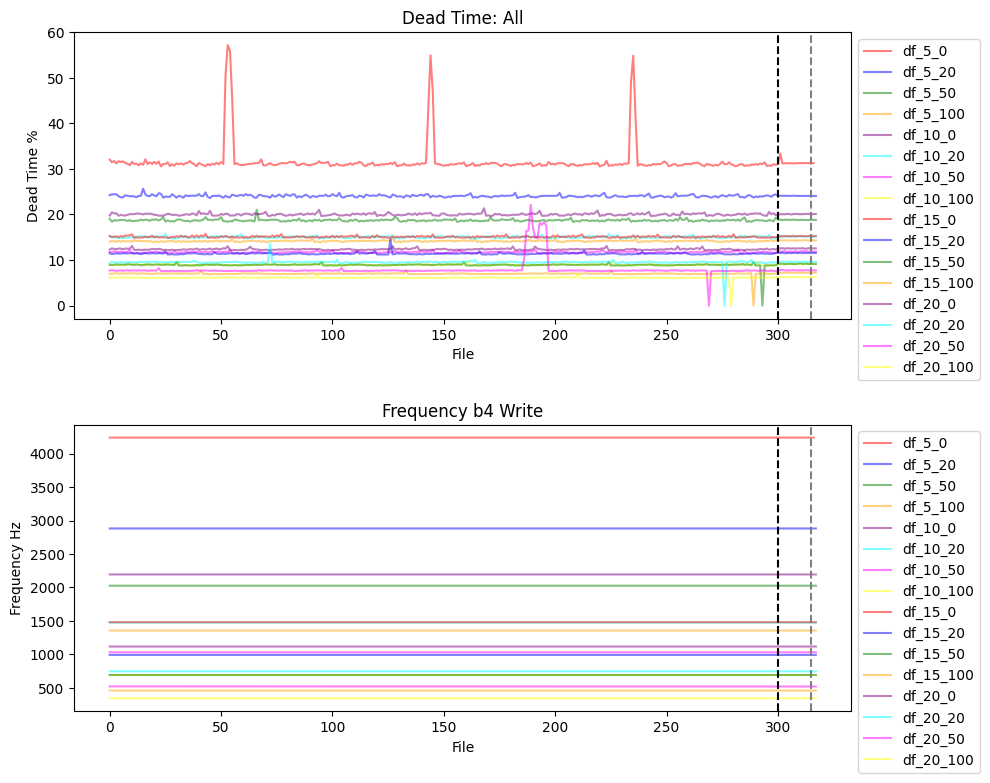

In [176]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_5_0', 'df_5_20', 'df_5_50', 'df_5_100',
    'df_10_0', 'df_10_20', 'df_10_50', 'df_10_100',
    'df_15_0', 'df_15_20', 'df_15_50', 'df_15_100',
    'df_20_0', 'df_20_20', 'df_20_50', 'df_20_100'
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Extract x data
    x = range(len(df.columns)-1)
    
    # Extract y data using the sample_delay_row approach
    sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
    y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
    
    # Extract y2 data using the sample_delay_row approach
    sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
    y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)

    # Plot dead time as a line plot
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

    # Plot frequency as a line plot
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time: All')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


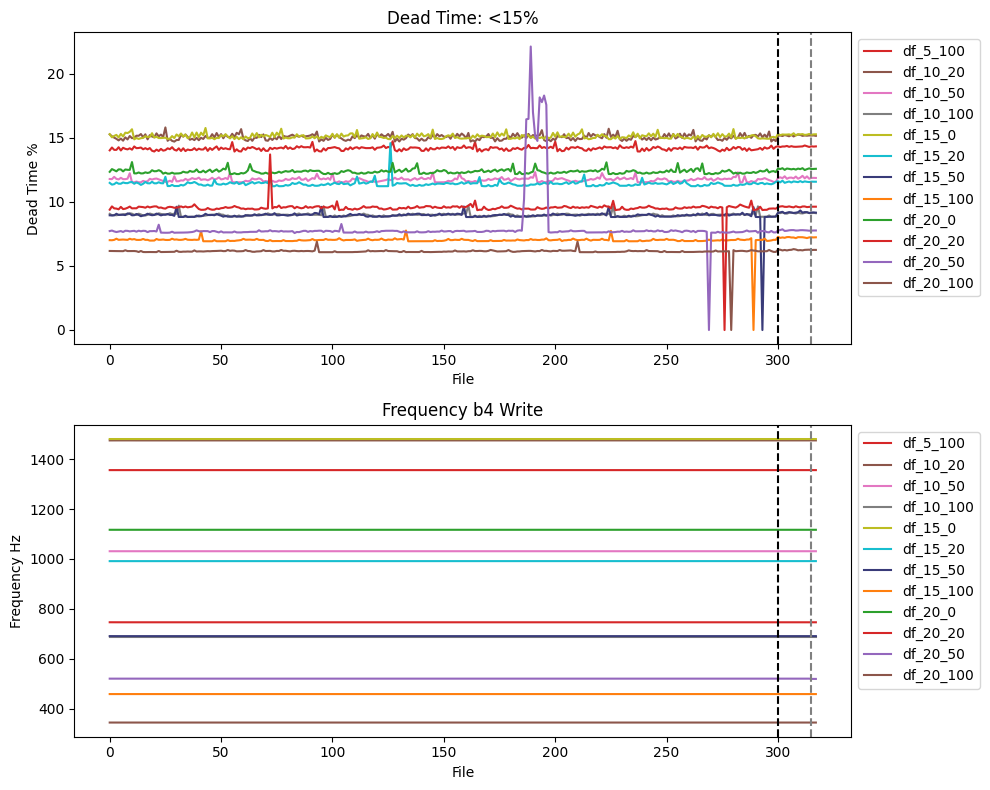

In [175]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

# Define colors for each DataFrame
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#393b79', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_5_0', 'df_5_20', 'df_5_50', 'df_5_100',
    'df_10_0', 'df_10_20', 'df_10_50', 'df_10_100',
    'df_15_0', 'df_15_20', 'df_15_50', 'df_15_100',
    'df_20_0', 'df_20_20', 'df_20_50', 'df_20_100'
]):
    # Get the DataFrame
    df = globals()[df_name]
    
    # Check if any column value in the row associated with "dead_time_percent" is less than 15
    condition_df = df[df.eq("dead_time_percent").any(axis=1)].iloc[0,1:].astype(float)

    if (condition_df[(condition_df < 15)]).any():
        # Extract x and y data
        x = range(len(df.columns)-1)
        
        # Extract y data using the sample_delay_row approach
        sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
        y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
        
        # Extract y2 data using the sample_delay_row approach
        sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
        y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
        
        # Plot dead time as line plot
        ax1.plot(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
        
        # Plot frequency as line plot
        ax2.plot(x, y2, color=colors[i % len(colors)], label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time: <15%')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion: samples averaged = 15 delay = 20 

In [177]:
####################################################################################################################
#                       Trial 1 struct 
# Folder: 15_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/struct/15_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/struct/15_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/struct/15_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_s15_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_s15_20
df_s15_20.to_csv("csv/df_s15_20.csv")


Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/3_300
min:  797.1
max:  1057.6
median:  804.0
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/60_15
min:  803.7
max:  807.8
median:  804.55
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/300_3
min:  804.6
max:  806.9
median:  805.75
Total differences calculated:  2


In [178]:
df_s15_20 = pd.read_csv('csv/df_s15_20.csv')
df_s15_20.columns.values[0] = "File Count"

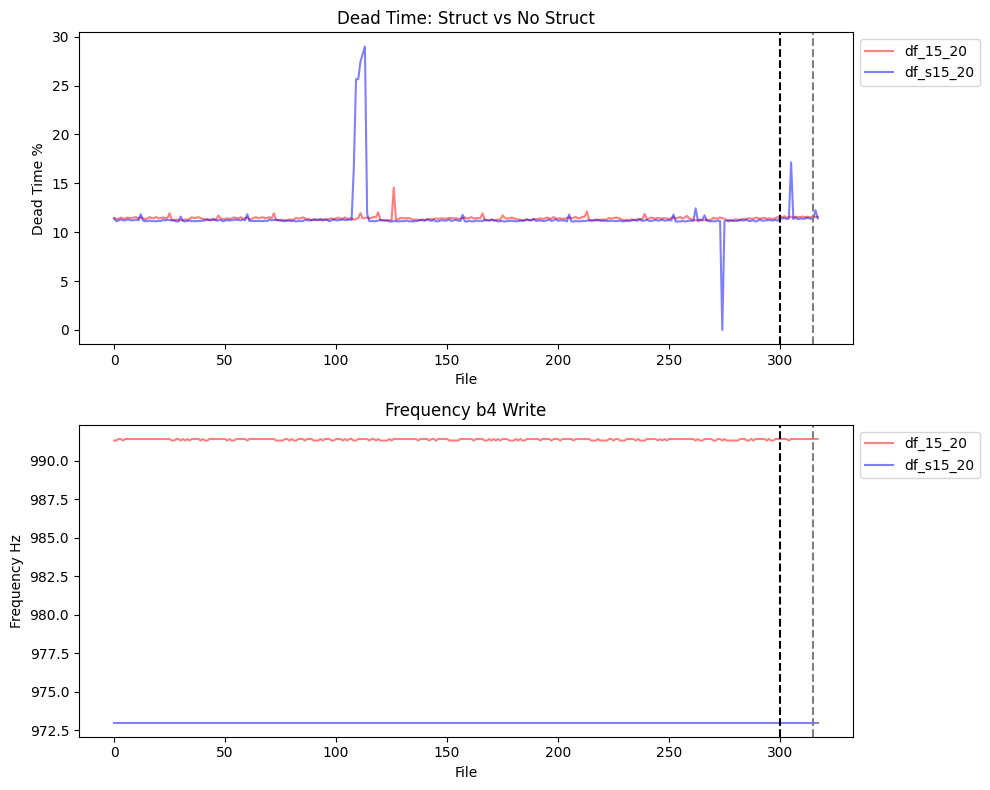

In [179]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_15_20', 'df_s15_20',
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Extract x data
    x = range(len(df.columns)-1)
    
    # Extract y data using the sample_delay_row approach
    sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
    y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
    
    # Extract y2 data using the sample_delay_row approach
    sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
    y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)

    # Plot dead time as a line plot
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

    # Plot frequency as a line plot
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time: Struct vs No Struct')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion: Do not use the pack command

In [180]:
####################################################################################################################
#                       Trial 2  
# Folder: sdfat - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial2/sdFat/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial2/sdFat/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial2/sdFat/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_sdfat = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_sdfat
df_sdfat.to_csv("csv/df_sdfat.csv")

####################################################################################################################
#                       Trial 2  
# Folder: exfat - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial2/exfat/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial2/exfat/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial2/exfat/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_exfat = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
# df_exfat
df_exfat.to_csv("csv/df_exfat.csv")


Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/3_300
min:  702.1
max:  732.5
median:  706.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/60_15
min:  706.9
max:  738.5
median:  707.6500000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/300_3
min:  708.6
max:  711.1
median:  709.85
Total differences calculated:  2
Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/3_300
min:  699.7
max:  749.9
median:  700.5
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/60_15
min:  700.8
max:  726.4
median:  701.3
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/300_3
min:  701.2
max:  701.3
median:  701.25

In [193]:
df_adafruit = df_15_20
df_adafruit = df_adafruit.iloc[:, 0:1].join(df_adafruit.iloc[:, 301:])

df_sdfat = pd.read_csv('csv/df_sdfat.csv')
df_sdfat.columns.values[0] = "File Count"
df_sdfat = df_sdfat.iloc[:, 0:1].join(df_sdfat.iloc[:, 301:])

df_exfat = pd.read_csv('csv/df_exfat.csv')
df_exfat.columns.values[0] = "File Count"
df_exfat = df_exfat.iloc[:, 0:1].join(df_exfat.iloc[:, 301:])

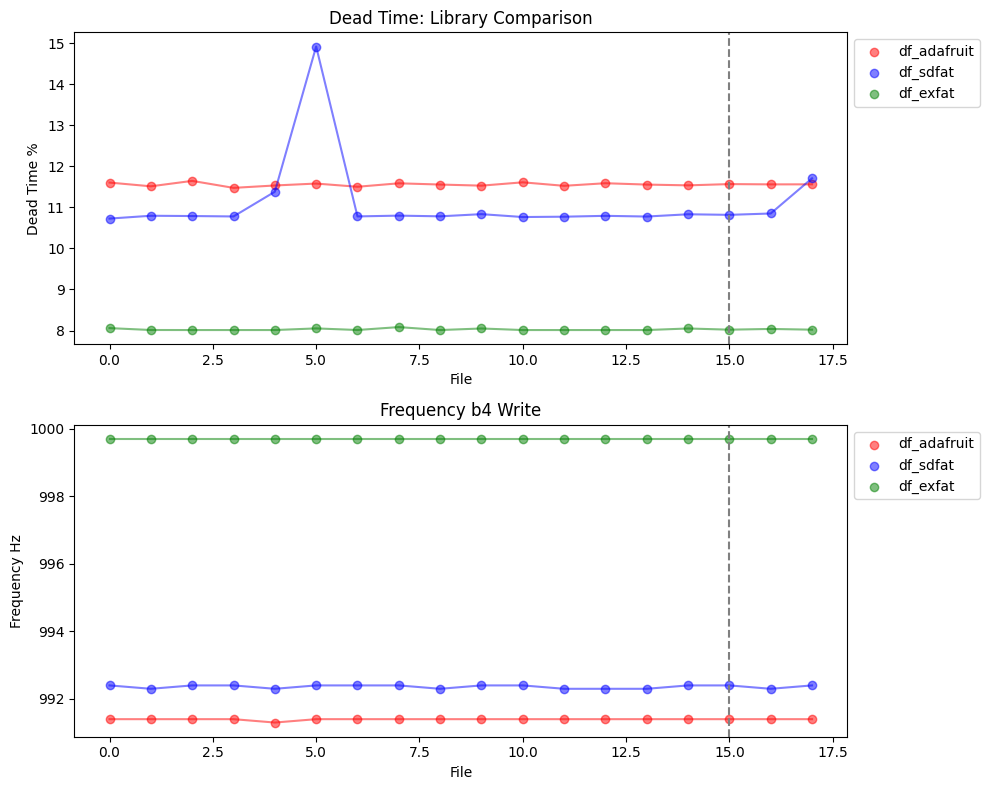

In [195]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_adafruit', 'df_sdfat', 'df_exfat'
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Extract x data
    x = range(len(df.columns)-1)
    
    # Extract y data using the sample_delay_row approach
    sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
    y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
    
    # Extract y2 data using the sample_delay_row approach
    sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
    y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)

    # Plot dead time as a line plot
    ax1.scatter(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5)

    # Plot frequency as a line plot
    ax2.scatter(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5)

# Set titles and labels
ax1.set_title('Dead Time: Library Comparison')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=15, color='gray', linestyle='--')
ax2.axvline(x=15, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion use exFat

In [197]:
import multi_file_mod as ml
import pandas as pd

####################################################################################################################
#                       Trial 3  
# standard  = exfat

####################################################################################################################
#                       Trial 3  
# Folder: flag 02 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
print('\nOfast ---------------------')
relative_path = 'data/trial3/Ofast/3_300'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df1 = ml.createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial3/Ofast/60_15'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df2 = ml.createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial3/Ofast/300_3'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df3 = ml.createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_ofast = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_ofast.to_csv("csv/df_ofast.csv")



Ofast ---------------------
Differences between last of one file and first of the next:
Start File:  data/trial3/Ofast/3_300
min (ms):  717.8
max (ms):  725.5
median (ms):  722.9
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial3/Ofast/60_15
min (ms):  722.9
max (ms):  727.4
median (ms):  723.95
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial3/Ofast/300_3
min (ms):  725.2
max (ms):  725.6
median (ms):  725.4000000000001
Total differences calculated:  2


In [201]:
df_standard = df_exfat

df_ofast = pd.read_csv('csv/df_ofast.csv')
df_ofast.columns.values[0] = "File Count"
df_ofast = df_ofast.iloc[:, 0:1].join(df_ofast.iloc[:, 301:])

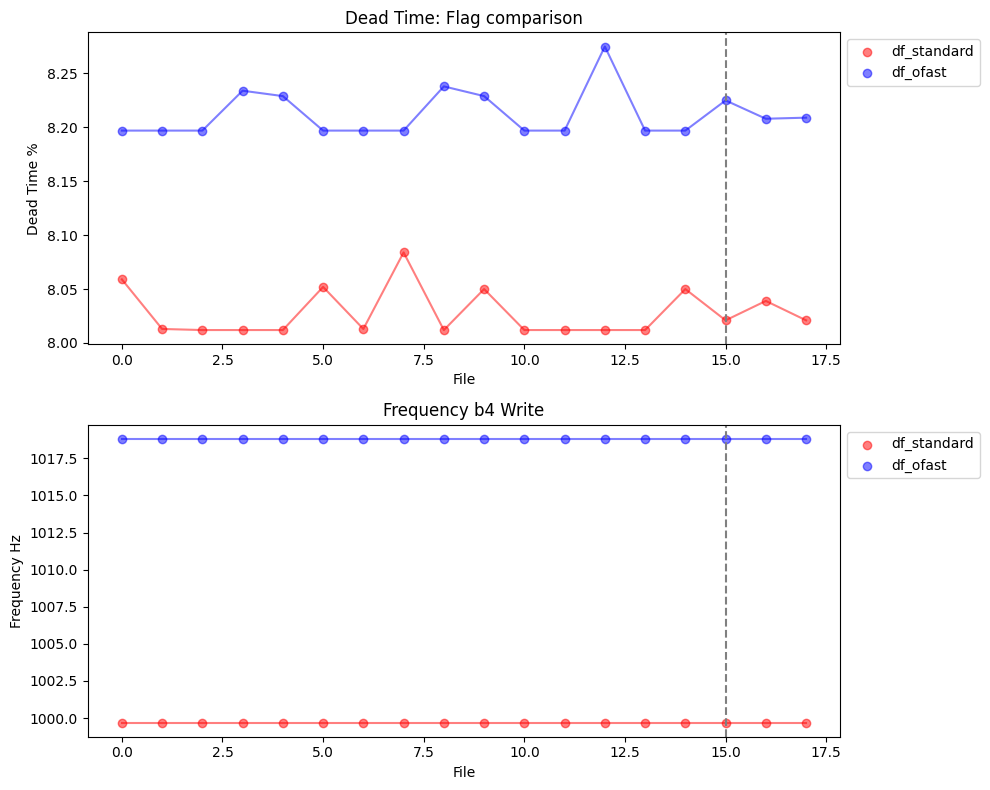

In [205]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_standard', 'df_ofast',
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Extract x data
    x = range(len(df.columns)-1)
    
    # Extract y data using the sample_delay_row approach
    sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
    y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
    
    # Extract y2 data using the sample_delay_row approach
    sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
    y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)

    # Plot dead time as a line plot
    ax1.scatter(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5)

    # Plot frequency as a line plot
    ax2.scatter(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5)

# Set titles and labels
ax1.set_title('Dead Time: Flag comparison')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=15, color='gray', linestyle='--')
ax2.axvline(x=15, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion use Standard

In [206]:
import multi_file_mod as ml
import pandas as pd
####################################################################################################################
#                       Trial 4  

# Standard = exFat

####################################################################################################################
#                       Trial 4  
# Folder: DMA512  - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
print('\nDMA512 Edit ---------------------')
# 60_15
relative_path = 'data/trial4/dma512/60_15'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df2 = ml.createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial4/dma512/300_3'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df3 = ml.createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_DMA512 = pd.concat([df2,df3], axis=1, ignore_index=True)
df_DMA512.to_csv("csv/df_DMA512.csv")


####################################################################################################################
#                       Trial 4  
# Folder: DMA128  - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
print('\nDMA128 Edit ---------------------')
# 60_15
relative_path = 'data/trial4/dma128/60_15'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df2 = ml.createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial4/dma128/300_3'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df3 = ml.createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_DMA128 = pd.concat([df2,df3], axis=1, ignore_index=True)
df_DMA128.to_csv("csv/df_DMA128.csv")


####################################################################################################################
#                       Trial 4  
# Folder: DMA64  - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
print('\nDMA64 Edit ---------------------')
# 60_15
relative_path = 'data/trial4/dma64/60_15'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df2 = ml.createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial4/dma64/300_3'
paths = ml.get_relative_paths(relative_path)
fsls = ml.inter_file_diff(relative_path)
df3 = ml.createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_DMA64 = pd.concat([df2,df3], axis=1, ignore_index=True)
df_DMA64.to_csv("csv/df_DMA64.csv")


DMA512 Edit ---------------------
Differences between last of one file and first of the next:
Start File:  data/trial4/dma512/60_15
min (ms):  700.0
max (ms):  703.5
median (ms):  700.45
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial4/dma512/300_3
min (ms):  696.0
max (ms):  696.3
median (ms):  696.15
Total differences calculated:  2

DMA128 Edit ---------------------
Differences between last of one file and first of the next:
Start File:  data/trial4/dma128/60_15
min (ms):  695.2
max (ms):  700.3
median (ms):  697.4
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial4/dma128/300_3
min (ms):  700.5
max (ms):  700.7
median (ms):  700.6
Total differences calculated:  2

DMA64 Edit ---------------------
Differences between last of one file and first of the next:
Start File:  data/trial4/dma64/60_15
min (ms):  700.1
max (ms):  700.8
median (ms):  700.4
T

In [207]:
df_standard

df_DMA512 = pd.read_csv('csv/df_DMA512.csv')
df_DMA512.columns.values[0] = "File Count"

df_DMA128 = pd.read_csv('csv/df_DMA128.csv')
df_DMA128.columns.values[0] = "File Count"

df_DMA64 = pd.read_csv('csv/df_DMA64.csv')
df_DMA64.columns.values[0] = "File Count"

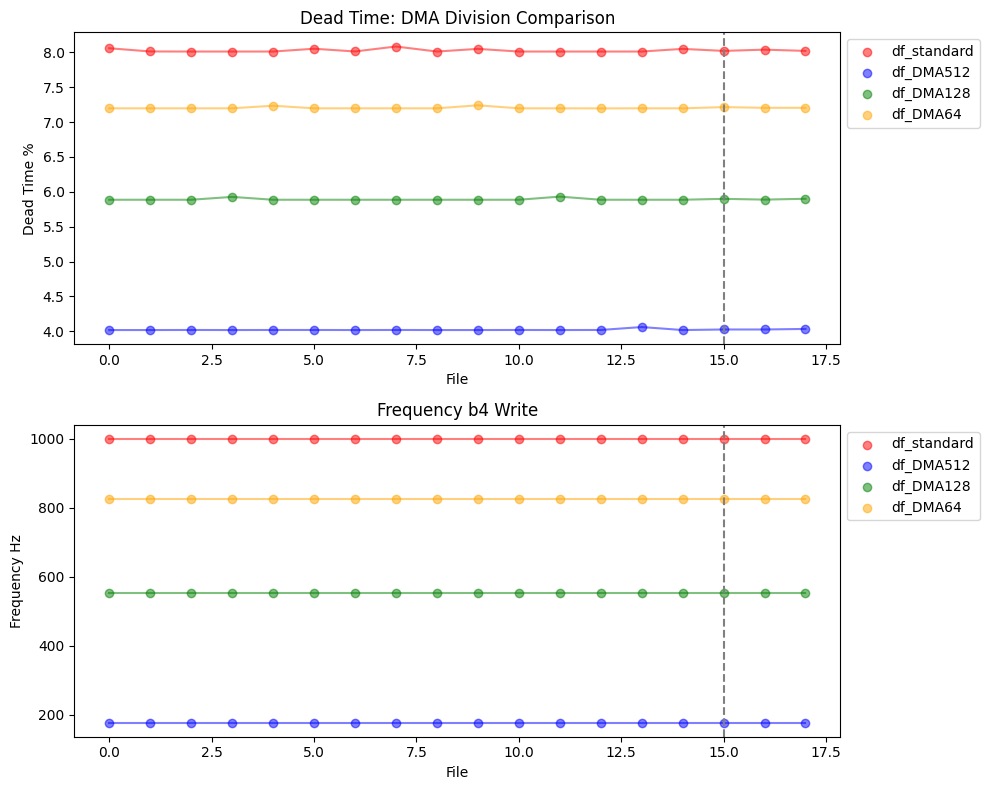

In [209]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_standard', 'df_DMA512',
    'df_DMA128', 'df_DMA64',
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Extract x data
    x = range(len(df.columns)-1)
    
    # Extract y data using the sample_delay_row approach
    sample_delay_row = df[df.eq("dead_time_percent").any(axis=1)]
    y1 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)
    
    # Extract y2 data using the sample_delay_row approach
    sample_delay_row = df[df.eq("freq_b4_write").any(axis=1)]
    y2 = sample_delay_row.iloc[0, 1:].astype(float)  # Exclude the first column (index)

    # Plot dead time as a line plot
    ax1.scatter(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5)

    # Plot frequency as a line plot
    ax2.scatter(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5)

# Set titles and labels
ax1.set_title('Dead Time: DMA Division Comparison')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=15, color='gray', linestyle='--')
ax2.axvline(x=15, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion Keep standard 